# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-wIzUAwxh-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 71227.44 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 98105.15 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 118739.12 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 130871.43 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 138421.04 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 145144.74 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 72648.72 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 106461.40 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 126619.92 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 137118.91 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 143950.83 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 149812.08 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.65 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.66 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.91 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.06 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.85 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.89 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.32 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.92 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.96 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.77 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.19 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.55 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.07 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.66 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.85 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.30 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 48.47 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.76 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.85 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.29 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.08 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 37.19 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.11 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.58 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.72 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.43 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.07 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.43 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.54 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 28.46 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 35.28 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.29 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:05, 26.99 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 34.15 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 39.39 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 42.77 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 44.78 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 44.49 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.50 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.53 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.37 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.53 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.23 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.47 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.78 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.27 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.96 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.01 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.63 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.53 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.86 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.19 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.55 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.13 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 48.81 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.04 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.63 examples/s]

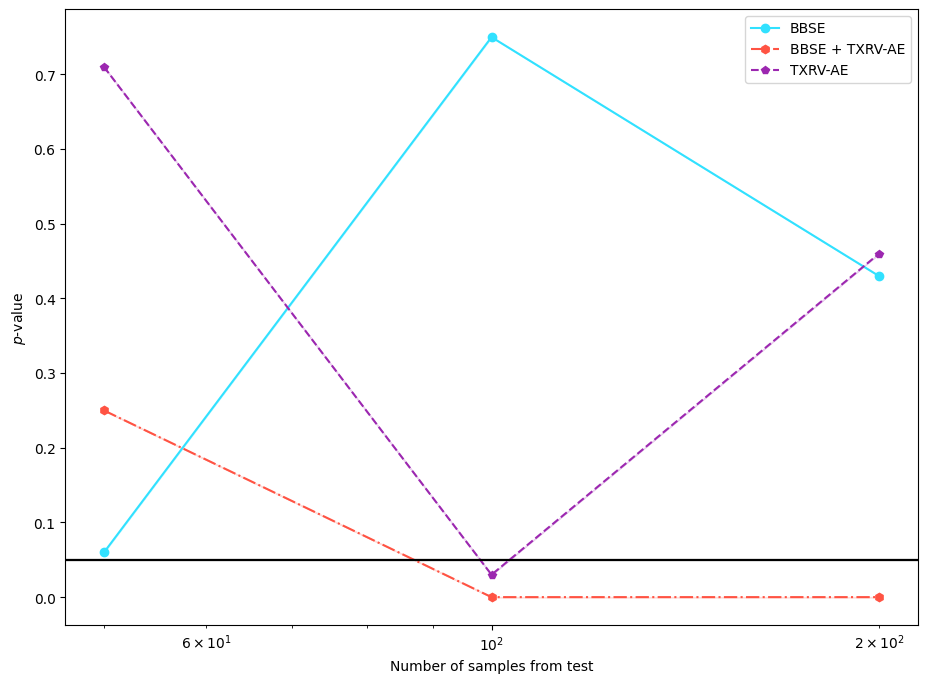

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.45 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.31 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.68 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.90 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.50 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.30 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.66 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.36 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.36 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.61 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.50 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.50 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.20 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.18 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.61 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.42 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.42 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.97 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.53 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.54 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.58 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.30 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.99 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.76 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.31 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.95 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.31 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.47 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.82 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.57 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.39 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.43 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.87 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.58 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.17 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 48.99 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.85 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.99 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.67 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.63 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.97 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.44 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.85 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.94 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 57.44 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.50 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.08 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.42 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.01 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.46 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.82 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.83 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.47 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.95 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.45 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.44 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.68 examples/s]

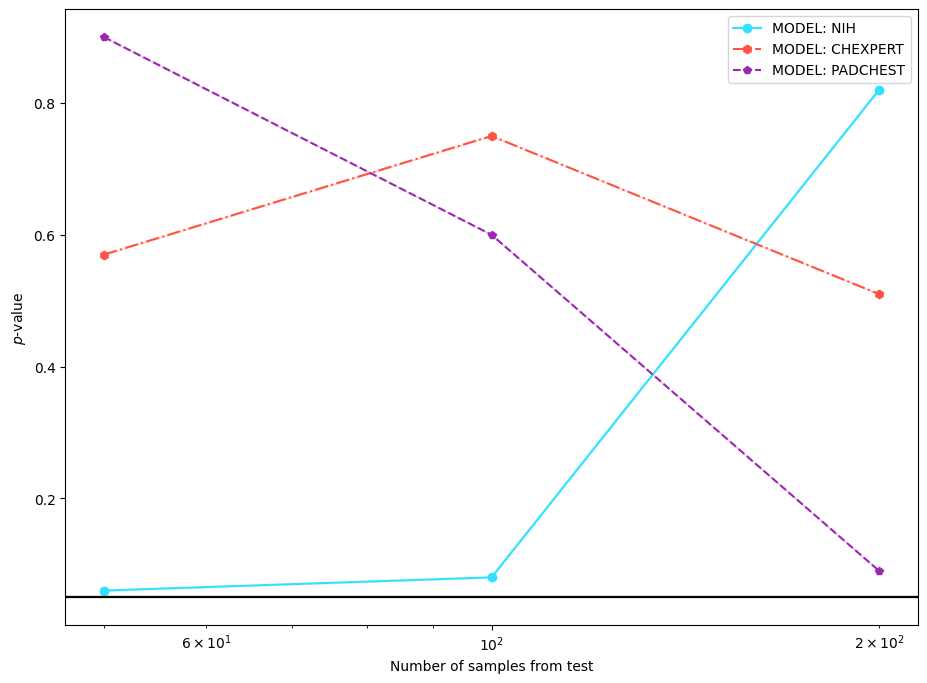

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 56200.82 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 73421.25 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 89491.15 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 95940.32 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 100623.25 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 103878.86 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51367.00 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 69917.01 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 84051.77 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 93057.24 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 104280.79 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 108244.44 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.53 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.26 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.81 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.83 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.99 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.34 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.76 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.75 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.54 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.08 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 32.25 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 41.44 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.05 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.83 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.60 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.34 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.33 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.23 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.02 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52059.57 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 71972.71 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 84255.23 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 94614.25 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 107575.60 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 118345.09 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  16%|█▌        | 18000/112120 [00:00<00:01, 48058.60 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 79023.60 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 91034.03 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 98025.83 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 102396.20 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 106119.74 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.38 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.16 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.11 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 50.56 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.87 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.78 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 57.21 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.03 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.08 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.01 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.79 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.63 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.98 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.67 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.67 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.45 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.91 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.26 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.03 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 56101.34 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 79440.41 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 88404.62 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 98998.78 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 102175.46 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 108854.06 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 49339.04 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 67995.03 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 81948.27 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 91477.46 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 98471.21 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 103265.84 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.42 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.75 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.41 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.27 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.52 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.01 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.39 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.79 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.76 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.37 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 32.04 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.62 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.65 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.57 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.70 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.49 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.02 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.05 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.84 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 50709.74 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 72326.73 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 84220.93 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 94980.86 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 106410.31 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 116632.36 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 48989.45 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 72579.06 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 86217.39 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 94751.54 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 98656.81 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 102798.55 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.67 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.46 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.63 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.68 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.63 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.23 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.70 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.74 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.83 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.57 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.24 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.34 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.05 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.38 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.36 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.60 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.65 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.91 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.61 examples/s]

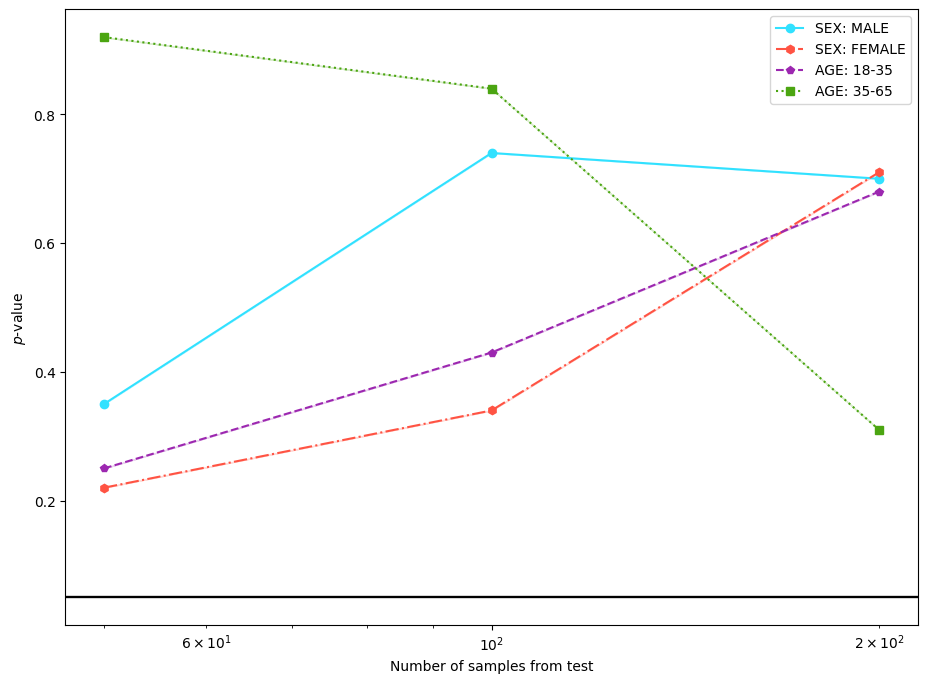

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.82 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.81 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.36 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 50.14 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 55.24 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.45 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 57.17 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.92 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.97 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.25 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.12 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.63 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.65 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.58 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.23 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.53 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.42 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.69 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.49 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.55 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.48 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.74 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.67 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.89 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.67 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.87 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.15 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.38 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.39 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.17 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.54 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.73 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 27.15 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.27 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.43 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.25 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.41 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.04 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.49 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.88 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.24 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.21 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.57 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.73 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.42 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.02 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.47 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.92 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.52 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.83 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.88 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.35 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.48 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.03 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.99 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.11 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.41 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.88 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.20 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.55 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.93 examples/s]

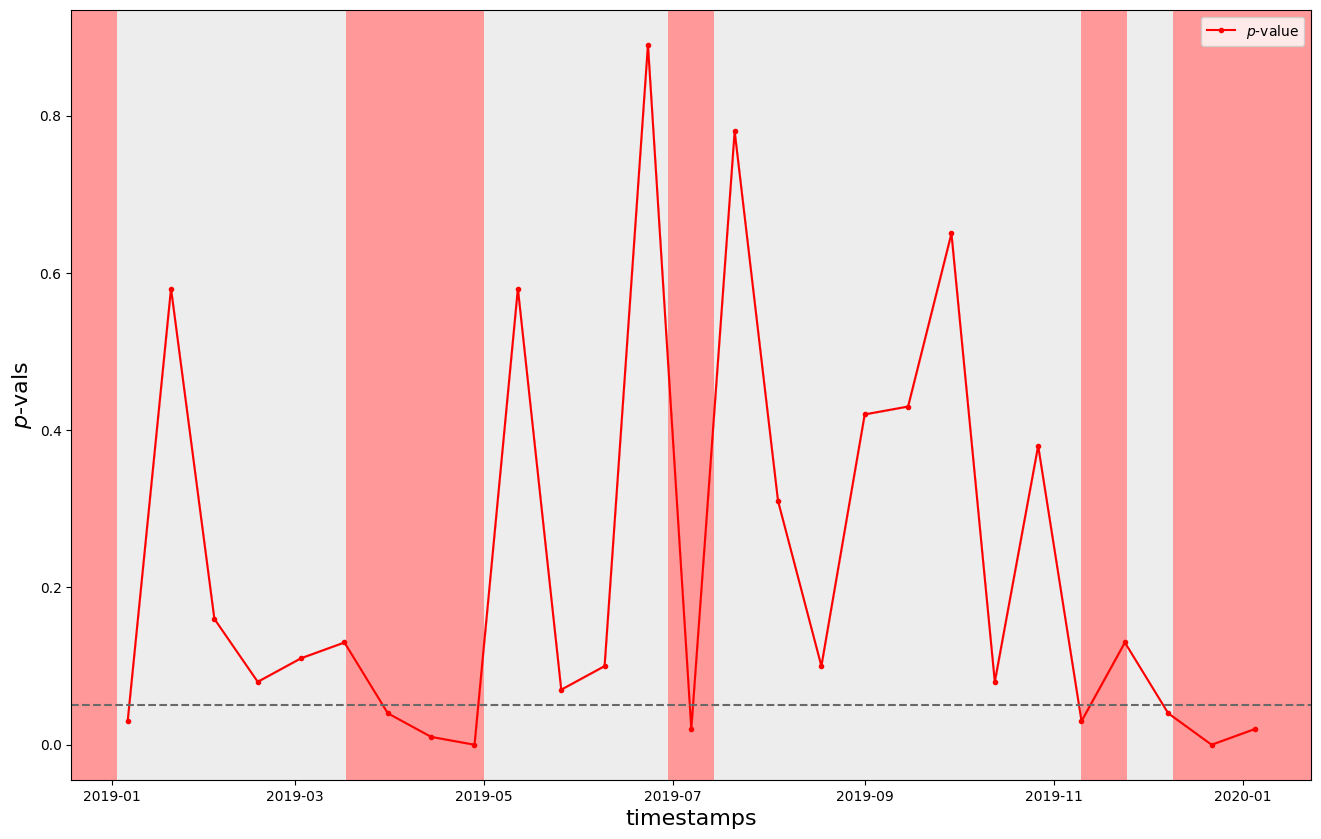

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)